<a href="https://colab.research.google.com/github/VijaySivak/Generalization-of-neural-networks-needs-rethinking/blob/main/Shuffled_Pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 Imports and Setup
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [ ]:
import torch.nn as nn
import torchvision.models as models

class CIFAR10_AlexNet(nn.Module):
    def __init__(self):
        super(CIFAR10_AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # CIFAR-10: 32×32 input
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # ✅ Replaces final MaxPool2d
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
# ⚙️ Training Function
def train(model, trainloader, testloader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list = []
    test_acc_list = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        train_acc_list.append(train_acc)

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_acc = 100. * correct / total
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")

    return train_acc_list, test_acc_list


In [ ]:
# 🌀 Pixel-Shuffled CIFAR-10 Dataset
perm = torch.randperm(32 * 32 * 3)

class PixelShuffledCIFAR(Dataset):
    def __init__(self, base_dataset):
        self.data = base_dataset.data
        self.targets = base_dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = torch.tensor(self.data[idx]).permute(2, 0, 1).float() / 255.0
        img = img.reshape(-1)[perm].reshape(3, 32, 32)
        img = (img - 0.5) / 0.5  # normalize
        label = self.targets[idx]
        return img, label


In [ ]:
# 📦 Load and Wrap CIFAR-10 Dataset
trainset_raw = CIFAR10(root='./data', train=True, download=True)
testset_raw = CIFAR10(root='./data', train=False, download=True)

trainset_shuffled = PixelShuffledCIFAR(trainset_raw)
testset_shuffled = PixelShuffledCIFAR(testset_raw)

trainloader_shuffled = DataLoader(trainset_shuffled, batch_size=128, shuffle=True, num_workers=2)
testloader_shuffled = DataLoader(testset_shuffled, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [ ]:
# 🏃‍♂️ Train the Model
model_shuffled = CIFAR10_AlexNet().to(device)
train_accs, test_accs = train(model_shuffled, trainloader_shuffled, testloader_shuffled, epochs=100)

Epoch 1: Train Acc = 20.94%, Test Acc = 27.34%
Epoch 2: Train Acc = 30.93%, Test Acc = 33.13%
Epoch 3: Train Acc = 35.89%, Test Acc = 37.21%
Epoch 4: Train Acc = 39.77%, Test Acc = 40.92%
Epoch 5: Train Acc = 43.27%, Test Acc = 38.99%
Epoch 6: Train Acc = 45.99%, Test Acc = 43.64%
Epoch 7: Train Acc = 48.86%, Test Acc = 46.68%
Epoch 8: Train Acc = 50.83%, Test Acc = 45.98%
Epoch 9: Train Acc = 52.43%, Test Acc = 46.37%
Epoch 10: Train Acc = 54.47%, Test Acc = 47.20%
Epoch 11: Train Acc = 55.69%, Test Acc = 47.15%
Epoch 12: Train Acc = 56.81%, Test Acc = 47.13%
Epoch 13: Train Acc = 57.86%, Test Acc = 47.03%
Epoch 14: Train Acc = 58.44%, Test Acc = 48.19%
Epoch 15: Train Acc = 59.71%, Test Acc = 47.64%
Epoch 16: Train Acc = 60.22%, Test Acc = 47.84%
Epoch 17: Train Acc = 61.28%, Test Acc = 48.09%
Epoch 18: Train Acc = 61.84%, Test Acc = 47.15%
Epoch 19: Train Acc = 62.29%, Test Acc = 47.43%
Epoch 20: Train Acc = 62.89%, Test Acc = 47.25%
Epoch 21: Train Acc = 63.76%, Test Acc = 47.42%
E

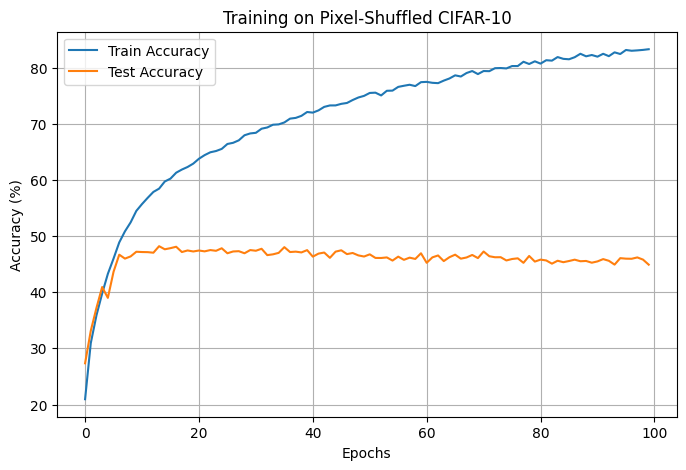

In [ ]:
# 📈 Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training on Pixel-Shuffled CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig("figure_shuffled_pixels.png")
plt.show()
